Import packages

In [58]:
import pandas as pd
import janitor
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


pd.options.display.max_seq_items = 2000

Ingest data

In [70]:
file_path = '../data/CredLens Data File - CredLens Data File.csv'
fc_data = pd.read_csv(file_path)
fc_data.shape

(1999, 28)

Column names 

In [61]:
column_names = fc_data.columns
column_names

Index(['FirstName', 'MiddleInitial', 'LastName', 'BirthDate', 'Degree',
       'Major1', 'MajorID1', 'CognateID1', 'StudentUID', 'ExpectedGradTerm',
       'StudentSSN', 'Email1', 'Address1', 'Address2', 'City', 'State',
       'ZipCode', 'Phone1', 'Phone2', 'MobilePhone', 'GraduationDate',
       'Cohort', 'Gender', 'EthnicOrigin', 'IsHispanic', 'CIPCode', 'Campus',
       'CostType'],
      dtype='object')

Clean the names 

In [71]:
fc_data = fc_data.clean_names()

Clean SSN 

In [67]:
# Remove dashes from SSNs, keeping NaN values unchanged
fc_data["ssn"] = fc_data["studentssn"].str.replace("-", "", regex=True)
# Keep rows where 'ssn' is either NaN or matches exactly 9 digits
fc_data["ssn"] = fc_data["ssn"].where(fc_data["ssn"].str.fullmatch(r"\d{9}"), np.nan)

fc_data.shape

(1999, 29)

Clean the dates in yyyymmdd format 

In [ ]:
fc_data["birthdate"] = pd.to_datetime(fc_data["birthdate"]).dt.strftime('%Y%m%d')
fc_data["graduationdate"] = pd.to_datetime(fc_data["graduationdate"]).dt.strftime('%Y%m%d')

Clean states names to code states 

In [27]:
#FC data is already in this format 
fc_data.state.value_counts().head()

state
MA    1809
FL      18
NH      14
RI      12
TX      11
Name: count, dtype: int64

Create age bucket

In [36]:
def calculate_age_bucket(row):
    """
    Calculate the age bucket based on birthdate and graduationdate.
    The input should be a row containing 'birthdate' and 'graduationdate' in 'yyyymmdd' format.
    """
    try:
        # Convert to datetime
        birthdate = datetime.strptime(row["birthdate"], '%Y%m%d')
        graduationdate = datetime.strptime(row["graduationdate"], '%Y%m%d')

        # Calculate age at graduation date
        age = graduationdate.year - birthdate.year - ((graduationdate.month, graduationdate.day) < (birthdate.month, birthdate.day))

        # Assign age bucket
        if age < 18:
            return "Under 18"
        elif 18 <= age <= 24:
            return "18-24"
        elif 25 <= age <= 34:
            return "25-34"
        elif 35 <= age <= 44:
            return "35-44"
        elif 45 <= age <= 54:
            return "45-54"
        elif 55 <= age <= 64:
            return "55-64"
        else:
            return "65 or over"
    except Exception as e:
        return "Invalid Date"

fc_data["age_bucket"] = fc_data.apply(calculate_age_bucket, axis=1)

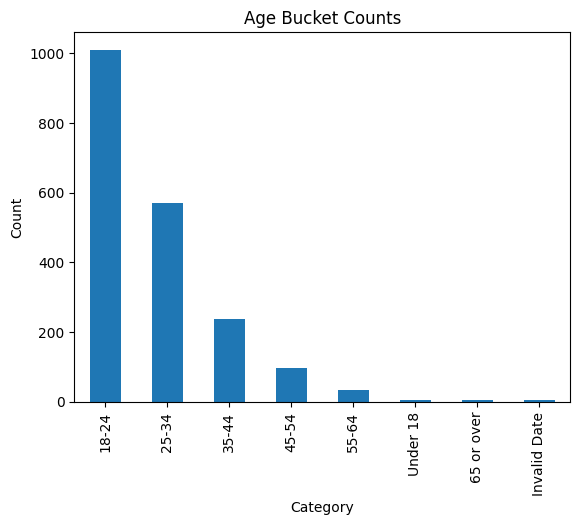

In [41]:
category_counts = fc_data['age_bucket'].value_counts()
category_counts.plot(kind='bar')
plt.title('Age Bucket Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Make address1 contain both address1 and address2 

In [73]:
fc_data['address1'] = fc_data['address1'] + (' ' + fc_data['address2']).fillna('')

Rename variables for golden record

Index(['firstname', 'middleinitial', 'lastname', 'birthdate', 'degree',
       'major1', 'majorid1', 'cognateid1', 'studentuid', 'expectedgradterm',
       'studentssn', 'email1', 'address1', 'address2', 'city', 'state',
       'zipcode', 'phone1', 'phone2', 'mobilephone', 'graduationdate',
       'cohort', 'gender', 'ethnicorigin', 'ishispanic', 'cipcode', 'campus',
       'costtype'],
      dtype='object')

In [ ]:
# Renaming multiple columns
df.rename(columns={
    'firstname': 'new_name',
    'another_old_name': 'another_new_name'
}, inplace=True)